In this notebook, we illustrate the use of the multitaper version of the complex demodulate (Thomson, 1995) and (Thomson et al., 2007). 

The demodulation code functions identically to the implementation in the R multitaper package and will use the Central England Temperature series as illustration, as in the R multitaper documentation.


In [1]:
using Multitaper, Statistics, Plots, DelimitedFiles, LsqFit

┌ Info: Precompiling Multitaper [a81958ac-9ec9-4086-814d-3ae87249a5e8]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1278


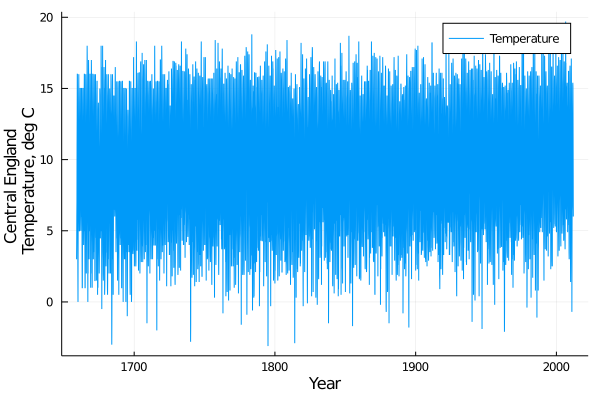

In [2]:
MTdir = dirname(dirname(pathof(Multitaper)))
cet = readdlm(MTdir*"/Examples/data/CETmonthly.dat")
yr = cet[:,1] .+ cet[:,2]/12
temp = cet[:,3]
plot(yr, temp, ylabel = "Central England \n Temperature, deg C",
    xlabel = "Year", label = "Temperature")

Consulting the spectrum, we see an obvious peak at 1 cycle per year (and a harmonic at 2 cyc/y!) characteristic of climate forcing. 

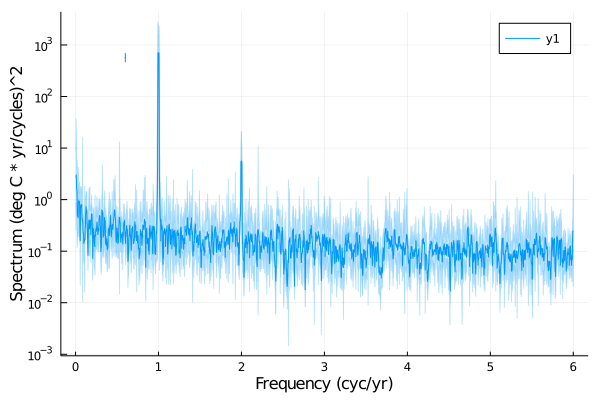

In [3]:
S = multispec(temp, NW = 3.0, K = 5, jk = true, dt=1.0/12)
sp = plot(S, xlabel = "Frequency (cyc/yr)",
    ylabel = "Spectrum (deg C * yr/cycles)^2")

To investigate the characteristics of this frequency in the time domain, we use the zeroth order Slepian sequence as a filter to extract frequencies nearby 1 cyc/y, shift them in frequency to the origin, and we obtain the complex demodulate. The idea is to use a small bandwidth in frequency. 

In [4]:
NW = 2.0
K = 1.0
# Block length is 15 years
blockLen = 15*12
rdm = demodulate(temp, K, NW, blockLen, true, 1.0/12, yr[1])
println("The bandwidth is $(NW/length(temp)) cyc/y.")

The bandwidth is 0.00047214353163361664 cyc/y.


The complex demodulate estimates the instantaneous amplitude and phase of the temperature series near the 1 cyc/yr frequency. 

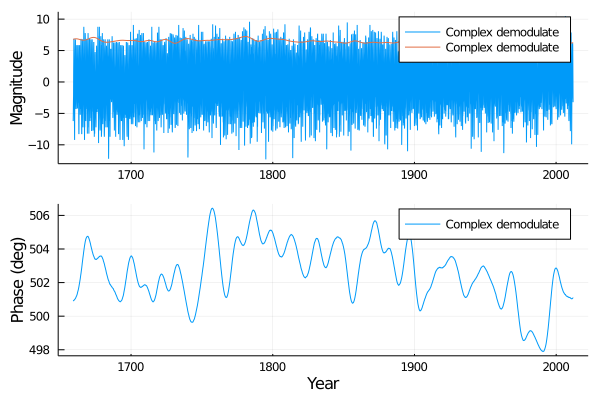

In [5]:
p1 = plot(yr, temp, label = "Temperature data")
p1 = plot!(rdm.time, rdm.mag, ylabel="Magnitude")
p2 = plot(rdm.time[2:end-1], rdm.phase[2:end-1] .+ 360.0,
    ylabel="Phase (deg)", xlabel = "Year", label = "Complex demodulate")
plot(p1, p2, layout = (2,1), label = "Complex demodulate")

Consulting the paper of Thomson 1995 in Science, the adjustment for the use of the Gregorian vs Julian calendar is relevant. Adjusting everything that happens before September 1752, we get the following result. We have also placed a least squares line on the plot that has slope that should more or less equal the precession constant.

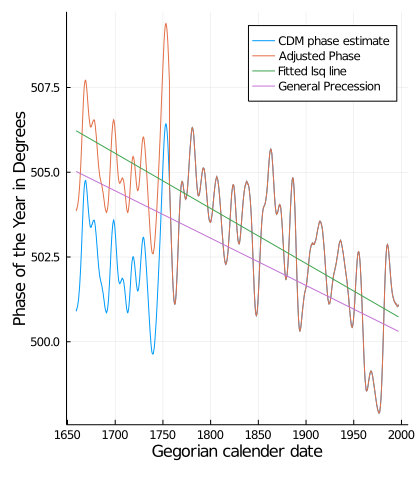

In [6]:
phase = rdm.phase
nJulOff = 1175
offsJul = 3*360/365
phaseAdj = copy(phase)
phaseAdj[1:nJulOff] = phase[1:nJulOff] .+ offsJul;

@. model(x, p) = p[1] + x*p[2]
p0 = [0.5, 0.5]
fit = curve_fit(model, yr[1:length(phase)], phaseAdj .+ 360.0, p0).param

plot(yr[1:(length(phase)-2)],phase[2:(end-1)] .+ 360.0, label = "CDM phase estimate",
    ylab="Phase of the Year in Degrees",
    xlab="Gegorian calender date", xtick=1650:50:2000, 
    size = (1.5*280,1.5*320), legend = :topright) 
plot!(yr[1:(length(phase)-2)], phaseAdj[2:(end-1)] .+ 360.0, label = "Adjusted Phase")
plot!(yr[1:(length(phase)-2)], fit[1] .+ fit[2]*yr[1:(length(phase)-2)],
    label="Fitted lsq line")
plot!(yr[1:(length(phase)-2)], fit[1] - 5 .+ (-50.256/(60*60))*yr[1:(length(phase)-2)],
    label="General Precession")

In [7]:
println("Precession Estimate: $(fit[2]*60*60) (arcseconds/yr)\n")

Precession Estimate: -58.50107669651988 (arcseconds/yr)



The R output does not actually match the figure 1 from the original paper, in fact it seems to be smaller than Thomson's estimate by about 28 degrees, and grossly overerestimates the precession constant of 50.256" per year. (Note the least squares package in Julia returns a different value of the slope than does the R abline, but verifiably the two curves above are identical.) 

Interestingly, adjustment of the bandwidth does not seem to make this go away.

# References:

Thomson, David J. "The seasons, global temperature, and precession." Science 268.5207 (1995): 59-68.

R multitaper package by Karim Rahim: https://github.com/krahim/multitaper/